# Step 1:  Data Cleaning



In [1]:
# Load NLTK resources (required only once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/apatecpetschnig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/apatecpetschnig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#load the data in 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df_promoting = pd.read_csv("data/data_promoting_eating_disorders.csv")
df_neutral = pd.read_csv("data/neutral_data.csv")

In [3]:
# Merge datasets
df = pd.concat([df_promoting, df_neutral], ignore_index=True)

In [4]:
df.head()

,Content,Origin,Eating_Disorder,Type,Method
0,"""I wish I had the willpower to starve myself l...",mixtral,1,Comment,Generated
1,"""Skinny is always going to be in, and fat is a...",mixtral,1,Comment,Generated
2,"""I can't even look at food without feeling gui...",mixtral,1,Comment,Generated
3,"""I'm on a strict diet, only eating 500 calorie...",mixtral,1,Comment,Generated
4,"""I don't know how she stays so thin, she must ...",mixtral,1,Comment,Generated


In [5]:
# Load internet_data.csv with ';' as the delimiter
# Specify usecols to only load the columns that exist in df
internet_data = pd.read_csv("data/internet_data.csv", delimiter=';', usecols=df.columns)

# Merge the newly loaded internet_data with the existing DataFrame df
df = pd.concat([df, internet_data], ignore_index=True)

## Delete duplicates

We will delete duplicates in case there a couple of them in the training data.

In [6]:
# Remove duplicates based on the 'Content' column
df = df.drop_duplicates(subset=['Content'])

## Deleting NaNs

We also delete rows in case they have "NaNs" in the content field

In [7]:
# Remove rows where 'Content' is NaN
df = df.dropna(subset=['Content'])
contents = df['Content'].values

## The distribution of data

We can see below that we have a nearly even data between training data that is classified as content that leads to an eating disorder and data that is not classified as content that that leads to an eating disorder.

In [8]:
# Count how many social media posts are classified as 0 and 1
class_counts = df['Eating_Disorder'].value_counts()
print("Counts of social media posts by classification:")
print(class_counts)

Counts of social media posts by classification:
Eating_Disorder
0.0    1065
1.0    1039
Name: count, dtype: int64


In [9]:
df.head()

,Content,Origin,Eating_Disorder,Type,Method
0,"""I wish I had the willpower to starve myself l...",mixtral,1.0,Comment,Generated
1,"""Skinny is always going to be in, and fat is a...",mixtral,1.0,Comment,Generated
2,"""I can't even look at food without feeling gui...",mixtral,1.0,Comment,Generated
3,"""I'm on a strict diet, only eating 500 calorie...",mixtral,1.0,Comment,Generated
4,"""I don't know how she stays so thin, she must ...",mixtral,1.0,Comment,Generated


### Saving the data without NaNs for the BERT-model as the pre-processing will be different for the bert model

In [10]:
df.to_csv('data/data_bert.csv', index=False)

# Step 2: Data Pre-Processing

This preprocessing function performs a series of text processing steps on the training data:

1. **Ensure String Format**: The function first ensures that the input text is in string format. This is crucial because the subsequent processing steps require the input to be in text form, and this ensures compatibility regardless of the initial data type.

2. **Tokenization**: This step involves breaking down the text into individual words or tokens. It’s a fundamental step in text preprocessing, allowing for the analysis of individual words within the context of the whole text.

3. **Stopword Removal**: Common words like "and", "the", and "in", known as stopwords, are usually irrelevant for analysis and can be removed. This step eliminates them, focusing the analysis on more meaningful words. This reduces the dataset size and potentially improves the model's performance by focusing on informative words.

4. **Stemming**: It is a technique to reduce words to their root form. Stemming cuts off prefixes and suffixes. This specific implementation uses stemming to normalize words (for example, "running" becomes "run"). This helps in generalizing different forms of the same word, allowing the model to learn from the base meaning rather than treating each form as a separate entity.

5. **Reconversion to Text**: After the tokens have been processed, they are joined back into a single string. This is necessary because most machine learning models expect the input as a sequence or collection of texts rather than isolated tokens.

#### Reasons for this pre-processing

- **Noise Reduction**: By removing stopwords and non-relevant components, the model can focus on significant features, reducing noise and potentially increasing accuracy.
  
- **Dimensionality Reduction**: Stemming and stopword removal decrease the number of unique words in the dataset. This simplifies the model’s feature space, which can lead to faster training times and reduce the risk of overfitting.
  
- **Improved Performance**: Overall, these preprocessing steps make the text more uniform and focused on the content that carries meaning, which can lead to improved model performance on tasks like classification.

In [11]:
# Preprocessing function
def preprocess_text(text):
    # Ensure that the input is a string
    text = str(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Re-convert to text
    return " ".join(tokens)

# Apply preprocessing to each row
df['Content_preprocessed'] = df['Content'].apply(lambda x: preprocess_text(str(x).lower()))

# Display the first few rows of the processed DataFrame
print(df.head())

                                             Content   Origin  \
0  "I wish I had the willpower to starve myself l...  mixtral   
1  "Skinny is always going to be in, and fat is a...  mixtral   
2  "I can't even look at food without feeling gui...  mixtral   
3  "I'm on a strict diet, only eating 500 calorie...  mixtral   
4  "I don't know how she stays so thin, she must ...  mixtral   

   Eating_Disorder     Type     Method  \
0              1.0  Comment  Generated   
1              1.0  Comment  Generated   
2              1.0  Comment  Generated   
3              1.0  Comment  Generated   
4              1.0  Comment  Generated   

                                Content_preprocessed  
0                    `` wish willpow starv like . ''  
1       `` skinni alway go , fat four-lett word . ''  
2  `` ca n't even look food without feel guilti . ''  
3        `` 'm strict diet , eat 500 calori day . ''  
4       `` n't know stay thin , must eat disord . ''  


# Step 3: Vectorization

### Why TF-IDF for this case?

**1. Semantic Importance:** TF-IDF gives importance to words according to how uniquely they can identify a category. In the context of eating disorders, certain phrases or expressions might be particularly indicative of harmful content or a neutral stance. TF-IDF will automatically assign higher weights to these terms, making the model more sensitive to the nuances of language in this context.

**2. Simplicity and Efficiency:** While advanced techniques like Word2Vec or GloVe offer rich semantic embeddings, they also introduce complexity and may require a larger dataset to effectively learn the contextual relationships between words. Given the sensitive nature of the task and potential limitations on data volume, TF-IDF's simpler statistical approach provides an efficient balance between capturing semantic importance and practicality. It's relatively easy to implement and understand, which is crucial for tasks requiring a transparent and interpretable model.

**3. Dimensionality Reduction:** TF-IDF can help in reducing the dimensionality of the feature set. By focusing on the words that are most descriptive (high TF-IDF scores) and discarding those that occur too frequently across all categories (low TF-IDF scores) or are too rare, it helps in keeping the model focused and manageable.

**4. Relevance to Text Classification:** TF-IDF has been proven to be highly effective for text classification tasks. 

In [12]:
contents = df['Content'].values

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the contents to create a feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(contents)

Now, `tfidf_matrix` is ready to be used as input for training models

In [13]:
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the DataFrame
print(tfidf_df.head())

# Having a look at the TF-IDF values
print(tfidf_df.iloc[0])

    10  100   11   12   13   14   15   16   17   18  ...  worthy  wow   xs  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   

   year  yes  yesterday  yoga  yogurt  zero  zip  
0   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
1   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
2   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
3   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
4   0.0  0.0        0.0   0.0     0.0   0.0  0.0  

[5 rows x 1000 columns]
10           0.0
100          0.0
11           0.0
12           0.0
13           0.0
            ... 
yesterday    0.0
yoga         0.0
yogurt       0.0
zero         0.0
zip          0.0
Name: 0, Leng

# Step 4: Exploratory data analysis

### Visualizing the istribution of classes

/var/folders/hd/n1358vbn09v5xngb1gmpdwvw0000gp/T/ipykernel_79194/2960682909.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


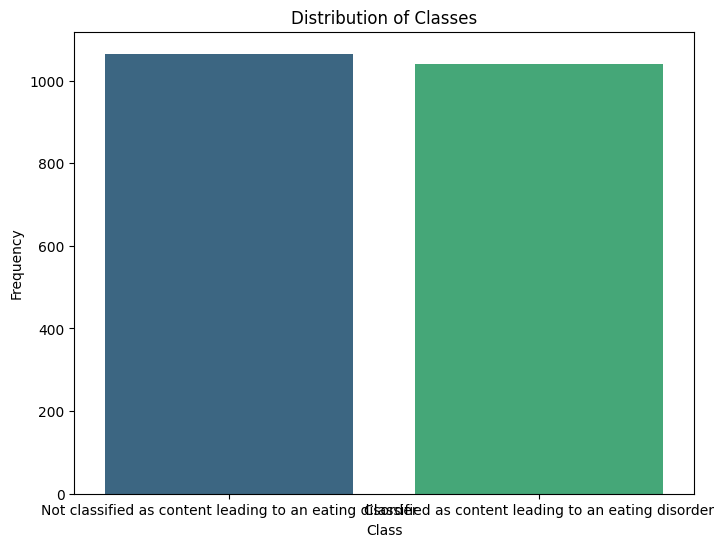

In [14]:
class_distribution = df['Eating_Disorder'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Classes')
plt.xlabel('Class')

plt.ylabel('Frequency')
plt.xticks(range(len(class_distribution.index)), ['Not classified as content leading to an eating disorder', 'Classified as content leading to an eating disorder'])
plt.show()

## Plotting the most frequent terms

Knowing the most frequent terms in each category helps in understanding the textual patterns that might differentiate between classes. This can inform pre-processing, feature selection, and even provide insights for refining the model.

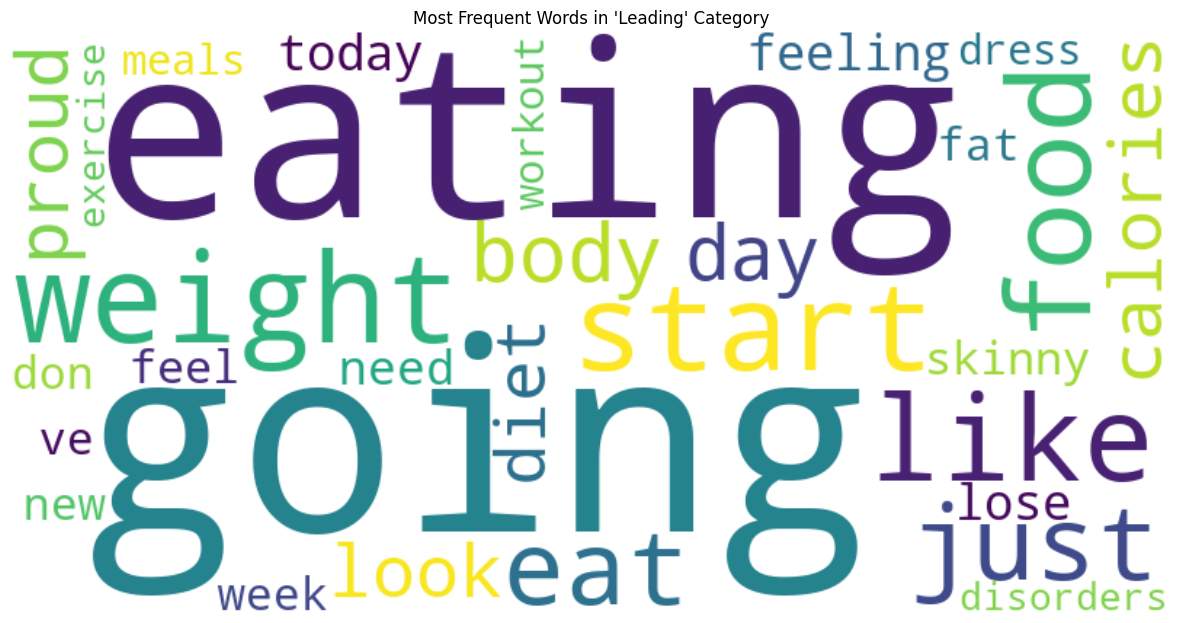

In [15]:
#identifying important terms 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to plot most frequent terms
def plot_most_frequent_words(texts, title="Most Frequent Words", ngram_range=(1,1), max_words=30):
    # Using CountVectorizer to find ngrams
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    bag_of_words = vectorizer.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:max_words]
    words_dict = dict(words_freq)
    
    # Generating word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_dict)
    
    # Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plotting for 'leading to eating disorders'
leading_texts = df[df['Eating_Disorder'] == 1]['Content']
plot_most_frequent_words(leading_texts, title="Most Frequent Words in 'Leading' Category")


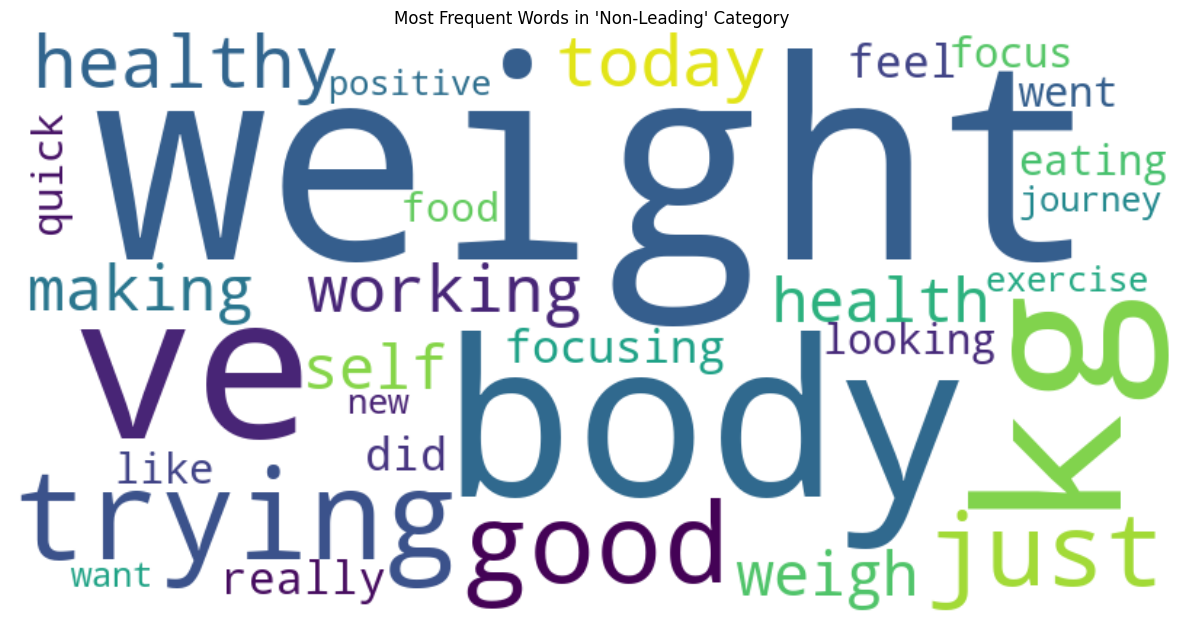

In [16]:
# Plotting for 'non-leading to eating disorders'
non_leading_texts = df[df['Eating_Disorder'] == 0]['Content']
plot_most_frequent_words(non_leading_texts, title="Most Frequent Words in 'Non-Leading' Category")

# Step 5: Model selection, training & evaluation of each model

We will split the data into training and testing sets, perform cross-validation, and train the model.

## Model Selection 

We'll train a Naive Bayes and a Random Forest.

**Why These Models?**
- **Naive Bayes:** It’s simple, fast, and often works well for text classification tasks, especially as a baseline.
- **Random Forest:** It’s a robust model that can handle both linear and non-linear relationships. This model might capture more complex patterns in the data.

## Evaluation

The code above also includes evaluation steps using `classification_report` and `confusion_matrix`, which will provide metrics like accuracy, precision, recall, and F1-score for each model. 

- **Accuracy:** Gives us the overall accuracy of the model.
- **Precision:** Indicates the proportion of positive identifications that were actually correct, which is crucial if the cost of false positives is high.
- **Recall (Sensitivity):** Indicates the proportion of actual positives that were identified correctly, crucial when it’s important to capture as many positives as possible.
- **F1-Score:** Provides a balance between Precision and Recall. It’s useful when we need a balance between detecting positives and avoiding false positives.

## Split Data into train and test data

In [17]:
X = tfidf_matrix  # Features from TF-IDF
y = df['Eating_Disorder'].values  # Target variable

# Split the data - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


# Traditional Machine Learning models

## Naive Bayes Algorithm

To perform hyperparameter tuning for the Naive Bayes classifier we will try different parameters `alpha` (additive smoothing parameter) and `fit_prior` (whether to learn class prior probabilities or not). 

Here are the general steps for hyperparameter tuning with `GridSearchCV`:

1. Defining the parameter we want to search over.
2. Setting up `GridSearchCV` with the classifier and parameter grid
3. Fit `GridSearchCV` to the data to perform the search
4. Evaluating the best model found.

In [18]:
from sklearn.naive_bayes import MultinomialNB
from joblib import dump
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Setting up the parameter grid to test.
# alpha is a smoothing parameter (Laplace/Lidstone).
# fit_prior determines whether to learn class prior probabilities or not.
parameters = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# Setting up the classifier to use with hyperparameter tuning.
nb_classifier = MultinomialNB()

# Setting up GridSearchCV to search for the best parameters.
clf = GridSearchCV(nb_classifier, parameters, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data.
clf.fit(X_train, y_train)

# Printing out the best parameters found by GridSearchCV.
print(f"Best Parameters: {clf.best_params_}")

# Retrieving the best model.
best_nb = clf.best_estimator_

# Prediction the best model on the test data.
y_pred = best_nb.predict(X_test)

# Model evaluation of the best model.
print("Naive Bayes (Best Model) Evaluation Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation for the best Naive Bayes model.
nb_scores = cross_val_score(best_nb, X, y, cv=5, scoring='accuracy')
print(f'Naive Bayes (Best Model) - Accuracy across 5 folds:', nb_scores)
print(f'Naive Bayes (Best Model) - Average Accuracy: {np.mean(nb_scores):.4f}')
print(f'Naive Bayes (Best Model) - Standard Deviation: {np.std(nb_scores):.4f}\n')

# Save the best Naive Bayes model.
dump(best_nb, 'best_naive_bayes_model.joblib')

Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Naive Bayes (Best Model) Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       208
         1.0       0.94      0.94      0.94       213

    accuracy                           0.94       421
   macro avg       0.94      0.94      0.94       421
weighted avg       0.94      0.94      0.94       421

Confusion Matrix:
 [[196  12]
 [ 12 201]]
Naive Bayes (Best Model) - Accuracy across 5 folds: [0.8432304  0.77909739 0.85035629 0.83610451 0.7952381 ]
Naive Bayes (Best Model) - Average Accuracy: 0.8208
Naive Bayes (Best Model) - Standard Deviation: 0.0283



['best_naive_bayes_model.joblib']

## Random forest algorithm 

### Information about the hyperparameters

1. **min_samples_split**: Minimum number of samples required to split an internal node. Higher values prevent creating nodes that represent very few instances and can help prevent overfitting.

2. **min_samples_leaf**: Minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. This may have the effect of smoothing the model.

3. **max_features**: The number of features to consider when looking for the best split. This can significantly impact performance and accuracy as it governs how many features each tree in the forest is allowed to choose from. The default value is "auto," which uses `sqrt(n_features)` for classification tasks.

4. **max_leaf_nodes**: The maximum number of leaf nodes a tree in the forest can have. If this parameter is specified, trees will expand until all leaves contain fewer than `min_samples_split` samples or until the maximum number of leaf nodes is reached.

5. **bootstrap**: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

6. **criterion**: The function to measure the quality of a split. "gini" for the Gini impurity and "entropy" for the information gain.

7. **max_samples**: If bootstrap is True, this parameter defines the number of samples to draw from X to train each base estimator.

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Setting up GridSearchCV with the classifier and parameter grid
clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                   scoring='accuracy', verbose=1, n_jobs=-1)

# Fitting GridSearchCV to the training data
clf.fit(X_train, y_train)

# Get the best estimator and its parameters
best_rf = clf.best_estimator_
best_params = clf.best_params_
print(f"Best Parameters: {best_params}")

# Prediction for the test data using the best model
y_pred = best_rf.predict(X_test)

# Model Evaluation
print("Random Forest Model Evaluation Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation for the best Random Forest model
rf_scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print(f'Random Forest - Accuracy across 5 folds:', rf_scores)
print(f'Random Forest - Average Accuracy: {np.mean(rf_scores):.4f}')
print(f'Random Forest - Standard Deviation: {np.std(rf_scores):.4f}\n')

# Save the best Random Forest model
dump(best_rf, 'best_random_forest_model.joblib')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       208
         1.0       0.90      0.96      0.93       213

    accuracy                           0.93       421
   macro avg       0.93      0.93      0.93       421
weighted avg       0.93      0.93      0.93       421

Confusion Matrix:
 [[186  22]
 [  9 204]]
Random Forest - Accuracy across 5 folds: [0.80997625 0.78384798 0.80285036 0.81947743 0.74285714]
Random Forest - Average Accuracy: 0.7918
Random Forest - Standard Deviation: 0.0271



['best_random_forest_model.joblib']

In [22]:
new_comment1 = ["I will starve myself because I want to be skinnier."]

new_comment_vector1 = tfidf_vectorizer.transform(new_comment1)

# Predict with Trained Naive Bayes Classifier (Using best_nb)
nb_prediction1 = best_nb.predict(new_comment_vector1)
print(f"Naive Bayes Prediction: {nb_prediction1[0]}") 

# Predict with Trained Random Forest Classifier (Using best_rf)
rf_prediction1 = best_rf.predict(new_comment_vector1)
print(f"Random Forest Prediction: {rf_prediction1[0]}")  

Naive Bayes Prediction: 1.0
Random Forest Prediction: 1.0


In [23]:
new_comment2 = ["My body weight is 60kg."]

new_comment_vector2 = tfidf_vectorizer.transform(new_comment2)

# Predict with Trained Naive Bayes Classifier (Using best_nb)
nb_prediction2 = best_nb.predict(new_comment_vector2)
print(f"Naive Bayes Prediction: {nb_prediction2[0]}") 

# Predict with Trained Random Forest Classifier (Using best_rf)
rf_prediction2 = best_rf.predict(new_comment_vector2)
print(f"Random Forest Prediction: {rf_prediction2[0]}")  

Naive Bayes Prediction: 0.0
Random Forest Prediction: 0.0
